# Did Tico manatee swim or surf the North Brazil Current?

In this notebook, we will explore the Tico manatee location data and compare this data with surface currents estimated by OSCAR. 

We also intend to perform a similar analysis to a GDP surface drifter that was in the region at the same time to prove that Tico did not swim to Venezuela, but was carried by the currents.

## Import modules and load GPS data 

In [752]:
import xarray as xr
import matplotlib.pyplot as plt
plt.style.use("project.mplstyle")

import matplotlib.patheffects as path_effects
import pandas as pd
import numpy as np
from dateparser import parse
import cmcrameri.cm as cmc
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import matplotlib.gridspec as gridspec

from matplotlib.dates import DayLocator,DateFormatter,HourLocator

proj = ccrs.PlateCarree()

In [221]:
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

In [409]:
# load data
df = pd.read_csv("../data/planilhaSateliteTicoR4.csv", delimiter=";")
df = df.rename(columns={"Classe Argos":"Class"})
df = df[~df["Class"].apply(lambda c: ("Uncertain" in c)|("Unresolved" in c))]

# parse timestamps
time = (df["Data"]+" "+df["Hora"]).apply(parse)

# set index
df = df[["Longitude","Latitude","Class"]]
df.index = time
df.index.name = "time"

ds = df.to_xarray()
ds = ds.assign(x = 111.32e3 * np.cos(np.deg2rad(ds.Latitude)) * ds.Longitude,y = 110.574e3 * ds.Latitude)
ds = ds.assign(x = ds.x-ds.x.isel(time=0), y = ds.y-ds.y.isel(time=0))
ds = ds.sortby("time")

ds = ds.rename(Longitude="longitude",Latitude="latitude")

Plotting positions separated by each ARGO class.

Error estimates:
 - **G (GPS):** 5 m
 - **Q / QFP (GPS corrected):** 5 to 500 m
 - **3 (Argos):** < 250 m
 - **2 (Argos):** 250 to 500 m
 - **1 (Argos):** 500 to 1500 m
 - **0 (Argos):** > 1500 m

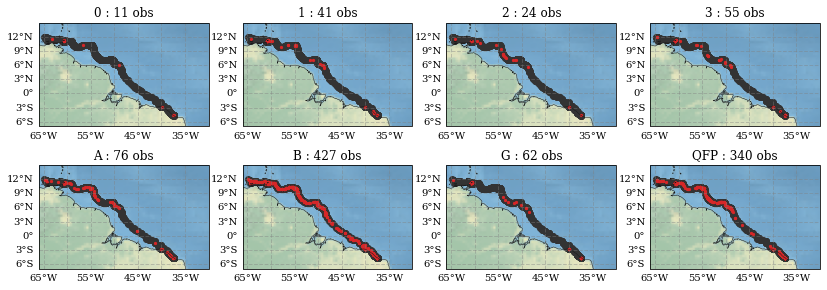

In [410]:
classes = np.unique(ds.Class)
fig,ax = plt.subplots(2, classes.size//2, figsize=(14,4.8), subplot_kw=dict(projection=proj))

ax = np.ravel(ax)
for i,c in enumerate(classes):
    ax[i].stock_img()
    ax[i].coastlines(color="0.1",lw=0.5)
    ax[i].set_extent([-66,-30,-7,15], crs=proj)
    gl = ax[i].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    ds.plot.scatter("longitude","latitude", ax=ax[i], color="0.2", transform=proj)
    ds.where(ds.Class==c).plot.scatter("longitude","latitude", ax=ax[i], color="tab:red", s=5)
    ax[i].set(title=f"{c} : {(ds.Class==c).sum().values} obs", xlabel="", ylabel="")


Lets keep QFP and G which are the most accurate positions, but there is part of the trajectory that mostly covered by B. We understand that we cannot estimate the error for B positions, but they follow the same path from the more accurate positions. Thus, let's keep B, but filter the data to remove spurious positions.

In [285]:
ds = ds.where((ds.Class=="QFP")|(ds.Class=="G")|(ds.Class=="B"), drop=True)

Most of the data is around 1h resolution

(array([141., 273., 119.,  55.,  27.,  31.,  10.,  12.,  10.,   8.,   7.,
          9.,   7.,   7.,   1.,   7.,   5.,   3.,   3.,   2.,   2.,   2.,
          0.,   2.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,  4.25,
         4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
         9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
        13.75, 14.25, 14.75, 15.25, 15.75, 16.25, 16.75, 17.25, 17.75,
        18.25, 18.75, 19.25, 19.75]),
 <BarContainer object of 39 artists>)

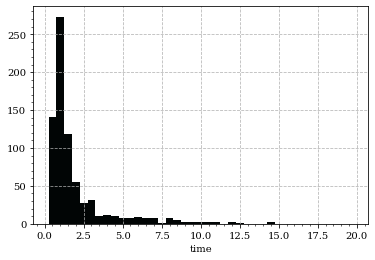

In [286]:
(ds.time.diff("time").astype("float")*1e-9/3600).plot.hist(bins=np.arange(0.25,20.25,0.5))

So, lets interpolate to this 1h.

In [757]:
tmin = ds.time.min().dt.strftime("%Y-%m-%d %H:%M").values.tolist()
tmax = ds.time.max().dt.strftime("%Y-%m-%d %H:%M").values.tolist()
dsi = ds.interp(time=pd.date_range(start=tmin,end=tmax,freq="1H"))[["longitude","latitude","x","y"]]

We perform the smoothing by passing a hanning filter of 2 days. In other words, Tico's position at each time will be replaced by the weighted average from 24 hours before to 24 hours after with a weight that is maximum at the center and zero at the ends.

In [758]:
window = 2*24+1 # hours
weight = xr.DataArray(np.hanning(window), dims=['window'])
smooth = lambda ds: ds.rolling(time=window,center=True,min_periods=1).construct('window').dot(weight)/weight.sum()

[Text(0, 0.5, '$\\Delta$y [km]'), Text(0.5, 0, '2022'), (-50.0, 2000.0)]

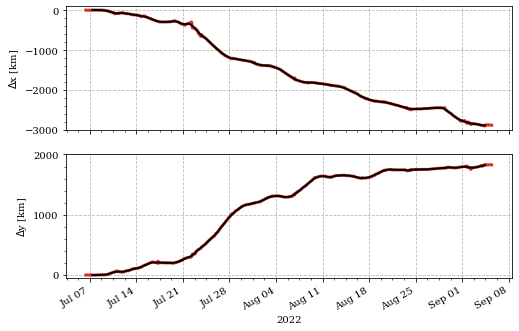

In [763]:
fmt = "%b %d"
fig,ax = plt.subplots(2,1,figsize=(8,5))

(smooth(dsi.x)*1e-3).plot(ax=ax[0],zorder=1e3)
(dsi.x*1e-3).plot(ax=ax[0],lw=3)

(smooth(dsi.y)*1e-3).plot(ax=ax[1],zorder=1e3)
(dsi.y*1e-3).plot(ax=ax[1],lw=3)


for a in ax:
    a.xaxis.set_major_locator(DayLocator(interval=7))
    a.xaxis.set_major_formatter(DateFormatter(fmt))
    a.set(yticks=np.arange(-3000,3000,1000))
    
ax[0].set(ylabel="$\Delta$x [km]",xlabel="",xticklabels=[],ylim=[-3000,100])
ax[1].set(ylabel="$\Delta$y [km]",xlabel="2022",ylim=[-50,2000])

In [452]:
dsi = dsi.assign({k:smooth(dsi[k]) for k in list(dsi)})
dsi = dsi.assign(u = dsi.x.differentiate("time", datetime_unit="s"), v = dsi.y.differentiate("time", datetime_unit="s"))
dsi = dsi.assign(spd = np.sqrt(dsi.u**2 + dsi.v**2))

[Text(0.5, 0, '2022'), Text(0, 0.5, 'Velocity [m$\\,$s$^{-1}$]')]

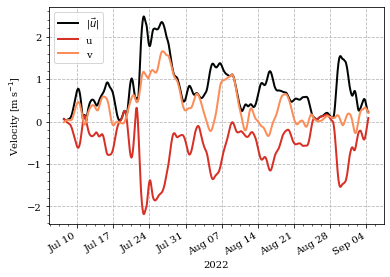

In [464]:
fmt = "%b %d"
fig,ax = plt.subplots()
dsi.spd.plot(label="|$\\vec{u}$|")
dsi.u.plot(label="u")
dsi.v.plot(label="v")
ax.legend()
ax.xaxis.set_major_locator(DayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter(fmt))

ax.set(xlabel="2022",ylabel="Velocity [m$\,$s$^{-1}$]")

## Load GEBCO bathymetry and OSCAR surface currents data

Now we load the GEBCO bathymetry data and OSCAR surface currents. The OSCAR data needed to be preprocessed to interpret timestamps, change reference longitudes, transpose coordinates to facilitate plots, and calculate velocity magnitude.

In [470]:
# load bathymetry
bat = xr.open_dataset("../data/gebco_2022_n21.4673_s-7.4048_w-68.6426_e-32.7393.nc").elevation
bat = bat.sel(lat=slice(-7.5,15,10), lon=slice(-66,-30,10))
ds = ds.assign(local_depth = bat.interp(lat = ds.latitude, lon = ds.longitude).drop(["lat","lon"]))

oscar = xr.open_mfdataset("../data/OSCAR_L4_OC_NRT_V2.0/*.nc")
oscar = oscar.assign_coords(time=[parse(time.strftime()) for time in oscar.time.values])
oscar = oscar.assign_coords(lon=(((oscar.lon + 180) % 360) - 180))
oscar = oscar.rename(lon="longitude", lat="latitude")
oscar = oscar.assign_coords(longitude=oscar.longitude, latitude=oscar.latitude)
oscar = oscar[["u","v"]].sel(latitude=slice(-7.4,15), longitude=slice(-66,-30))
oscar = oscar.transpose("latitude","longitude","time")
oscar = oscar.assign(spd=np.sqrt(oscar.u**2 + oscar.v**2))
oscar = oscar.load()


## Load Sea Surface Salinity data (SMAP)

In [466]:
# load SMAP Sea Surface Salinity data
sss = xr.open_mfdataset("../data/SMAP/*")["smap_sss"].sortby("latitude")
sss = sss.sel(latitude=slice(-7.4,15), longitude=slice(-66,-30)).load().interpolate_na("time")

## Load Precipitation data (IMERG)

In [594]:
rain = (
    xr.open_mfdataset("../data/IMERG/*")["precipitationCal"]
    .rename(lon="longitude", lat="latitude")
    .sel(latitude=slice(-7.4,15), longitude=slice(-68,-29))
).load().T#.rolling(longitude=10,latitude=10,center=True).mean()

time = [datetime(y,m,d) for y,m,d in zip(rain.time.dt.year,rain.time.dt.month,rain.time.dt.day)]
rain = rain.assign_coords(time=time)

/tmp/ipykernel_3489683/3972876975.py:7: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  time = [datetime(y,m,d) for y,m,d in zip(rain.time.dt.year,rain.time.dt.month,rain.time.dt.day)]


## Load Drifter data (GDP)

In [573]:
drifters = xr.open_dataset("../data/GDP/OSMCV4_DUO_SURFACE_TRAJECTORY_f1dd_538b_d63d.nc")
drifters = drifters.set_index(row=["platform_id","time"]).unstack("row")[["longitude","latitude"]].interpolate_na("time").interp(time=dsi.time)
# drifters = drifters.groupby("platform_id")

In [574]:
driftersi = drifters.sel(time=slice(ti,tj))

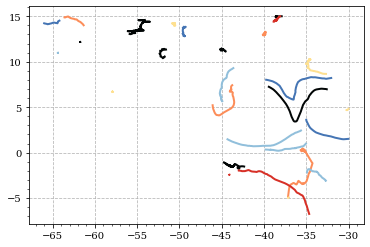

In [575]:
_ = plt.plot(driftersi.longitude.T,driftersi.latitude.T)

## Plot maps for trajectory and ocean currents

We will now make a figure of the Tico trajectory by superimposing the average current field for the entire period. As the period is very long, the trajectory does not necessarily match the current field presented. In this map, we add markers for every 7 days of the trajectory to provide a temporal variation.

/tmp/ipykernel_3489683/1973034429.py:64: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(C,ax=ax,


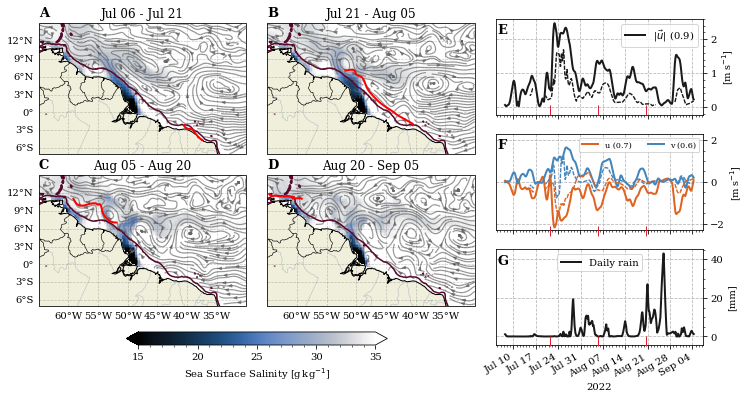

In [753]:
timei = pd.date_range(start=ds.time.min().values, end=ds.time.max().values, freq="1d")[::15][:-1]

lablat = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$N' if lat>0 else f'{-lat}$^\\circ$S'
lablon = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$E' if lat>0 else f'{-lat}$^\\circ$W'

xticks = np.arange(-180,180,5)
yticks = np.arange(-90,90,5)

kw = dict(
    sss = dict(x="longitude",y="latitude",cmap=cmc.oslo,vmin=15,vmax=35, transform=proj,add_colorbar=False),
    oscar = dict(x="longitude",y="latitude",u="u",v="v", color=(0.4,0.4,0.4,0.7), density=1.8, transform=proj,linewidth=1.2,arrowsize=0.6),
)

fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(hspace=0.5,wspace=0.1)
gs = gridspec.GridSpec(6, 4)

ax = [
    fig.add_subplot(gs[:3,0],projection=proj),
    fig.add_subplot(gs[:3,1],projection=proj),
    fig.add_subplot(gs[3:,0],projection=proj),
    fig.add_subplot(gs[3:,1],projection=proj)
]

for a, label in zip(ax,('A', 'B', 'C', 'D')):
    a.text(0, 1.03, label, transform=a.transAxes,
      fontsize=13, fontweight='bold', va='bottom', ha='left')


ax = np.ravel(ax)
dtmax = pd.to_datetime(str(ds.time.max().values)).strftime('%Y-%m-%d %H:%M:%S')
i = 0
for ti,tj,a in zip(timei.tolist(), timei[1:].tolist()+[dtmax], ax):
    # if i==1:
    #     break
    # i=i+1
    a.add_feature(land_10m)
    a.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='0.8')
    a.add_feature(cfeature.BORDERS, linewidth=0.6, edgecolor='black')
    a.coastlines()
    a.plot(dsi.sel(time=slice(ti,tj)).longitude,dsi.sel(time=slice(ti,tj)).latitude,color="red",zorder=1e2)
    C = sss.sel(time=slice(ti,tj)).mean("time").plot(ax=a,**kw["sss"])
    # sss.sel(time=slice(ti,tj)).mean("time").plot.contour(ax=a,levels=[10,25],colors=["0.2"],transform=proj)
    oscar.sel(time=slice(ti,tj)).mean("time").plot.streamplot(ax=a,**kw["oscar"])    
    # rain.sel(time=slice(ti,tj)).sum("time").plot.contour(ax=a,**kw["rain"])
    bat.plot.contour(ax=a,levels=[-200],linestyles="-",transform=proj,colors="#580a2b",linewidths=1.5)
    
    a.set_extent([-65,-30,-7,15],crs=proj)
    a.set_title(pd.to_datetime(ti).strftime("%b %d")+" - "+pd.to_datetime(tj).strftime("%b %d"))

gl = []
for a in ax:
    gl.append(a.gridlines(draw_labels=True, linewidth=0.7, color='black', alpha=0.2, linestyle='--'))
gl = np.array(gl)
    
for gli in gl:
    gli.top_labels = False
    gli.right_labels = False
for gli in gl[[0,1]]:
    gli.bottom_labels = False
for gli in gl[[1,3]]:
    gli.left_labels = False
    
fig.colorbar(C,ax=ax,
             label="Sea Surface Salinity [g$\,$kg$^{-1}$]",
             orientation="horizontal",extend="both",fraction=0.04,pad=0.08
             
)


ax = [
    fig.add_subplot(gs[:2,2]),
    fig.add_subplot(gs[2:4,2]),
    fig.add_subplot(gs[4:,2]),
]


for a, label in zip(ax,('E', 'F', 'G')):
    a.text(0.01, 0.95, label, transform=a.transAxes,
      fontsize=13, fontweight='bold', va='top', ha='left')

R = lambda x,y,d="time": ((x*y).sum(d)/(np.sqrt((x**2).sum(d))*np.sqrt((y**2).sum(d)))).values

oscari = oscar.interp(time=dsi.time,longitude=dsi.longitude,latitude=dsi.latitude)
raini = rain.interp(longitude=dsi.longitude,latitude=dsi.latitude,time=dsi.time)

fmt = "%b %d"

dsi.spd.plot(label=f"|$\\vec{{u}}$| ({R(dsi.spd,oscari.spd):0.1f})",ax=ax[0],color="0.1")
oscari.spd.plot(ax=ax[0],color="0.1",linestyle=(0,(3,1)),lw=1.4)

dsi.u.plot(label=f"u ({R(dsi.u,oscari.u):0.1f})",ax=ax[1],color="#dd6422")
dsi.v.plot(label=f"v ({R(dsi.v,oscari.v):0.1f})",ax=ax[1],color="#4485bb")

oscari.u.plot(ax=ax[1],color="#dd6422",linestyle=(0,(3,1)),lw=1.4)
oscari.v.plot(ax=ax[1],color="#4485bb",linestyle=(0,(3,1)),lw=1.4)

raini.plot(ax=ax[2],color="0.1",label="Daily rain")

ax[0].legend(loc=1)
ax[1].legend(ncol=2,loc=1,fontsize=8)
ax[2].legend(loc="upper center")

for a in ax:
    # _ = [a.axvline(t,linestyle="-",alpha=0.4) for t in timei[1:]]
    ylim = a.get_ylim()
    a.plot(timei[1:],[ylim[0]]*timei[1:].size,
           marker="|",lw=0,color="#de2135",
           clip_on=False,zorder=1e4, markersize=10,
    )
    a.yaxis.set_label_position("right")
    a.yaxis.tick_right()
    a.xaxis.set_minor_locator(DayLocator(interval=1))
    a.xaxis.set_major_locator(DayLocator(interval=7))
    a.xaxis.set_major_formatter(DateFormatter(fmt))
    
ax[0].set(xlabel="",xticklabels=[],ylabel="[m$\,$s$^{-1}$]")
ax[1].set(ylim=[-2.3,2.3],xlabel="",xticklabels=[],ylabel="[m$\,$s$^{-1}$]")
ax[2].set(xlabel="2022",ylabel="[mm]")

fig.savefig("../img/sss_currents_rain.png", dpi=300, facecolor="w")

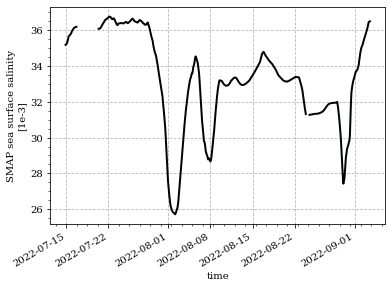

In [756]:
sss.interp(longitude=dsi.longitude,latitude=dsi.latitude,time=dsi.time).plot()

## Code below might not work

/tmp/ipykernel_3489683/2110724288.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(C, label="Velocity magnitude [m/s]")
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


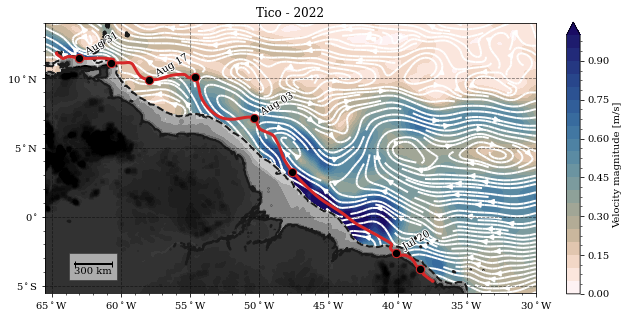

In [725]:
fig, ax = plt.subplots(figsize=(11,5))

C = np.sqrt(oscar.u**2 + oscar.v**2).mean("time").plot.contourf(levels=np.arange(0,1.05,0.05), cmap=cmc.lapaz_r, vmin=-0.05, vmax=1, add_colorbar=False, zorder=0)
[a.set_edgecolor("face") for a in C.collections]
oscar.mean("time").plot.streamplot("longitude", "latitude", "u", "v", color=(1,1,1,1), density=2.5,zorder=0)
fig.colorbar(C, label="Velocity magnitude [m/s]")


ax.plot(dsi.longitude, dsi.latitude, color="tab:red", linewidth=3, zorder=2)

dsw = dsi.interp(time=pd.date_range(start=ds.time.min().values, end=ds.time.max().values, freq="7d"))
dsw.plot.scatter("longitude", "latitude", zorder=2, edgecolor="tab:red", color="k", s=70)

for i in np.arange(0,dsw.time.size,2):
    loni = dsw.isel(time=i).longitude.values
    lati = dsw.isel(time=i).latitude.values
    ti = pd.to_datetime(str(dsw.isel(time=i).time.values))
    text = ax.text(loni,lati,ti.strftime('  %b %d'), rotation=30)
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                       path_effects.Normal()])
    
C = bat.rolling(lon=5,lat=5).mean().where((bat>-200)&(bat<0)).plot.contourf(levels=10, vmin=-200, vmax=100, cmap="Greys", extend="max", zorder=1, add_colorbar=False)
[a.set_edgecolor("face") for a in C.collections]
C = bat.rolling(lon=5,lat=5).mean().where(bat>0).plot.contourf(levels=50, vmin=-4000, vmax=800, cmap="Greys", extend="max", zorder=1, add_colorbar=False)
[a.set_edgecolor("face") for a in C.collections]
bat.plot.contour(levels=[-150,0], colors=["0.1"], extend="neither", add_colorbar=False, zorder=1)




lni,lti = -62,-3.4
ref = 300#km
ax.plot([lni-ref/2/111.3,lni+ref/2/111.3],[lti,lti],marker="|", color="k")
ax.text(lni,lti-0.2,f"{ref} km",ha="center",va="top")
height = 2
rectangle = plt.Rectangle((lni-1.3*ref/2/111.3,lti-0.6*height), 1.3*ref/111.3, height, fc='w',ec="0.2", alpha=0.6)
plt.gca().add_patch(rectangle)


lablat = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$N' if lat>0 else f'{-lat}$^\\circ$S'
lablon = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$E' if lat>0 else f'{-lat}$^\\circ$W'

xticks = np.arange(-180,180,5)
yticks = np.arange(-90,90,5)

ax.axis("scaled")
ax.grid(True, linestyle="--",zorder=3, alpha=0.5, color="0.0")
_ = ax.set(
    ylabel='',
    xlabel='',
    xticks=xticks,
    yticks=yticks,
    xticklabels=list(map(lablon,xticks)),
    yticklabels=list(map(lablat,yticks)),
    xlim=[-65.5,-30],
    ylim=[-5.5,14],
    title=f"Tico - {ds.time.dt.year.values[0]}"
)

fig.savefig("../img/map_trajectory.pdf", dpi=300, facecolor="w", bbox_inches="tight")
fig.savefig("../img/map_trajectory.eps", dpi=300, facecolor="w", bbox_inches="tight")
fig.savefig("../img/map_trajectory.png", dpi=300, facecolor="w", bbox_inches="tight")


In a better representation, we present average fields for each 10-day trajectory, showing only the positions of the G and Q classes. Due to a shorter average, the trajectory better follows the current patterns. We plan to add a link to a video to make the trajectory easier to watch.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


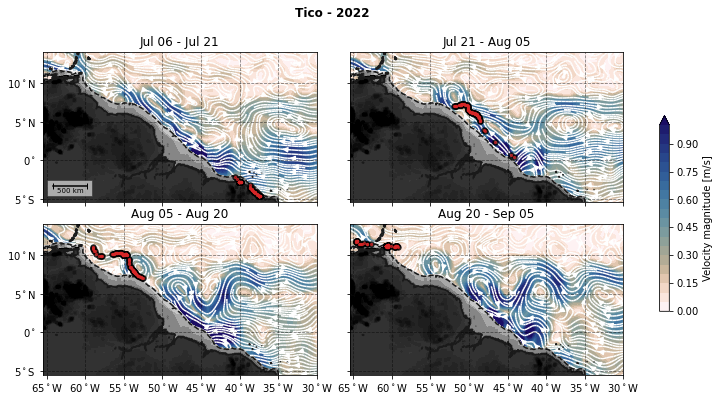

In [351]:
timei = pd.date_range(start=ds.time.min().values, end=ds.time.max().values, freq="1d")[::15][:-1].astype("str")

lablat = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$N' if lat>0 else f'{-lat}$^\\circ$S'
lablon = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$E' if lat>0 else f'{-lat}$^\\circ$W'

xticks = np.arange(-180,180,5)
yticks = np.arange(-90,90,5)

fig, ax = plt.subplots(int(np.ceil(timei.size/2)),2, figsize=(13,6))
fig.subplots_adjust(hspace=0.12, wspace=0.12)
ax = np.ravel(ax)
for ti,tj,a in zip(timei, timei[1:].tolist()+[ds.time.max().values], ax):
    ds.sel(time=slice(ti,tj)).plot.scatter("Longitude","Latitude", s=30, color="k", ax=a, zorder=2, alpha=0.7)
    ds.sel(time=slice(ti,tj)).plot.scatter("Longitude","Latitude", s=5, color="tab:red", ax=a, zorder=2, alpha=0.7)
    
    C = bat.rolling(lon=5,lat=5).mean().where((bat>-200)&(bat<0)).plot.contourf(ax=a,levels=10, vmin=-200, vmax=100, cmap="Greys", extend="max", zorder=1, add_colorbar=False)
    [ci.set_edgecolor("face") for ci in C.collections]
    C = bat.rolling(lon=5,lat=5).mean().where(bat>0).plot.contourf(ax=a,levels=50, vmin=-4000, vmax=800, cmap="Greys", extend="max", zorder=1, add_colorbar=False)
    [ci.set_edgecolor("face") for ci in C.collections]
    bat.plot.contour(ax=a,levels=[-150,0], colors=["0.1"], extend="neither", add_colorbar=False, zorder=1)
    
    oscari = oscar.sel(time=slice(ti,tj)).mean("time")
    C = np.sqrt(oscari.u**2 + oscari.v**2).plot.contourf(ax=a, levels=np.arange(0,1.05,0.05), cmap=cmc.lapaz_r, vmin=-0.05, vmax=1, add_colorbar=False, zorder=0)
    [ci.set_edgecolor("face") for ci in C.collections]
    oscari.plot.streamplot("longitude", "latitude", "u", "v", ax=a, color=(1,1,1,1), density=2.5,zorder=0)
    
    a.axis("scaled")
    a.grid(True, linestyle="--",zorder=3, alpha=0.5, color="0.0")
    _ = a.set(
        ylabel='',
        xlabel='',
        xticks=xticks,
        yticks=yticks,
        xticklabels=list(map(lablon,xticks)),
        yticklabels=list(map(lablat,yticks)),
        xlim=[-65.5,-30],
        ylim=[-5.5,14],
        title=pd.to_datetime(ti).strftime("%b %d")+" - "+pd.to_datetime(tj).strftime("%b %d"),
    )
    
_ = [a.set(xticklabels=[]) for a in ax[:2]]
_ = [a.set(yticklabels=[]) for a in ax[1::2]]
fig.suptitle(f"Tico - {ds.time.dt.year.values[0]}"+30*" ", fontweight="bold")
fig.colorbar(C, ax=ax, label="Velocity magnitude [m/s]", shrink=0.6)


lni,lti = -62,-3.4
ref = 500#km
ax[0].plot([lni-ref/2/111.3,lni+ref/2/111.3],[lti,lti],marker="|", color="k", zorder=4)
ax[0].text(lni,lti-0.2,f"{ref} km",ha="center",va="top", zorder=4, fontsize=7)
height = 2
rectangle = plt.Rectangle((lni-1.3*ref/2/111.3,lti-0.6*height), 1.3*ref/111.3, height, fc='w',ec="0.2", alpha=0.6, zorder=3)
ax[0].add_patch(rectangle)


fig.savefig("../img/maps_trajectory.pdf", dpi=300, facecolor="w", bbox_inches="tight")
fig.savefig("../img/maps_trajectory.eps", dpi=300, facecolor="w", bbox_inches="tight")
fig.savefig("../img/maps_trajectory.png", dpi=300, facecolor="w", bbox_inches="tight")

In [186]:
drifters = xr.open_dataset("../data/GDP/OSMCV4_DUO_SURFACE_TRAJECTORY_f1dd_538b_d63d.nc")
drifters = drifters.groupby("platform_id")

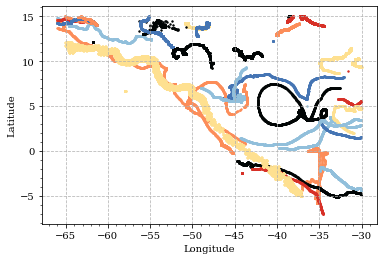

In [206]:
for d_id,drifter in drifters:
    drifter.plot.scatter("longitude","latitude",s=2)
ds.plot.scatter("Longitude","Latitude",marker="X")

In [207]:
drifter = drifter.assign_coords(time=drifter.time).rename(row="time").sortby("time")
drifter = drifter.assign(x = 111.32e3 * np.cos(np.deg2rad(drifter.latitude)) * drifter.longitude,y = 110.574e3 * drifter.latitude)
drifter = drifter.assign(x = drifter.x-drifter.x.isel(time=0), y = drifter.y-drifter.y.isel(time=0))
drifter = drifter.assign(u = drifter.x.differentiate("time", datetime_unit="s"), v = drifter.y.differentiate("time", datetime_unit="s"))
drifter = drifter.assign(spd = np.sqrt(drifter.u**2 + drifter.v**2))

In [208]:
oscari = oscar.interp(time=drifter.time,longitude=drifter.longitude,latitude=drifter.latitude)

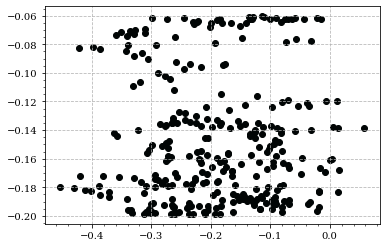

In [209]:
plt.scatter(drifter.u,oscari.u)

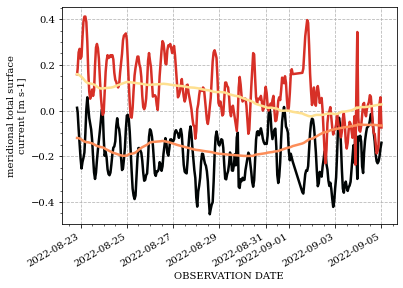

In [213]:
drifter.u.plot()
drifter.v.plot()

oscari.u.plot()
oscari.v.plot()

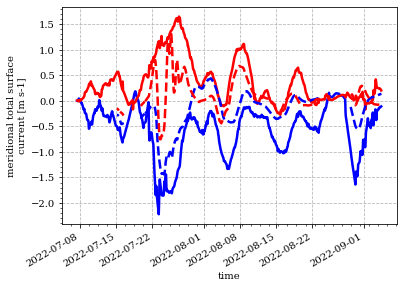

In [339]:
oscari = oscar.interp(time=dsi.time,longitude=dsi.longitude,latitude=dsi.latitude)

dsi.u.plot(color="blue")
dsi.v.plot(color="red")

oscari.u.plot(color="blue",linestyle="--")
oscari.v.plot(color="red",linestyle="--")